In [64]:
import torchvision
from research_task_utils import *
import importlib
from torchsummary import summary

# importlib.reload(research_task_utils)

In [65]:
batchsize = 512
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor()
    ]
)
traindata = torchvision.datasets.CIFAR100(root="./dataset", train=True, download=True, transform=transform)
testdata = torchvision.datasets.CIFAR100(root="./dataset", train=False, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(traindata, batch_size=batchsize, shuffle=True)
testloader = torch.utils.data.DataLoader(testdata, batch_size=batchsize, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [66]:
from collections import OrderedDict
class ConvBlock(torch.nn.Module):
    def __init__(self, num_of_convs, c_in, c_out, wh):
        super().__init__()
        
        self.num_of_convs = num_of_convs
        self.c_in = c_in
        self.c_out = c_out
        self.wh = wh
        
        layers = []
        
        assert num_of_convs > 0
        layers.append(('conv1',torch.nn.Conv2d(c_in, c_out, kernel_size=3, stride=1, padding=1)))
        for k in range(1, num_of_convs):
            layers.append((f'relu_{k}',torch.nn.ReLU()))
            layers.append((f'conv_{k+1}',torch.nn.Conv2d(c_out, c_out, kernel_size=3, stride=1, padding=1)))
            
        layers.append(('bn',torch.nn.BatchNorm2d(c_out)))
        layers.append((f'relu_{num_of_convs}',torch.nn.ReLU()))
        
        self.layers = torch.nn.Sequential(OrderedDict(layers))
        
    def num_of_params(self, only_trainable: bool = False):
        parameters = list(self.parameters())
        if only_trainable:
            parameters = [p for p in parameters if p.requires_grad]
        unique = {p.data_ptr(): p for p in parameters}.values()
        return sum(p.numel() for p in unique)
        
    def forward(self, x):
        return self.layers(x)
    
def num_of_convBlock_params(num_of_convs, c_in, c_out, wh):
    num = c_in*c_out*9 + c_out # first conv layer
    num += (num_of_convs - 1)*(c_out*c_out*9 + c_out) # other conv layers
    num += 2*c_out # BN params
    return num

In [67]:
class architecture2():
    def __init__(self, c1, c2, c3, c4, k1, k2, k3, k4):
        self.c1 = c1
        self.c2 = c2
        self.c3 = c3
        self.c4 = c4
        self.k1 = k1
        self.k2 = k2
        self.k3 = k3
        self.k4 = k4
        
        self.num_of_params = (num_of_convBlock_params(num_of_convs=k1, c_in=3, c_out=c1, wh=32) +
                              num_of_convBlock_params(num_of_convs=k2, c_in=c1, c_out=c2, wh=16) +
                              num_of_convBlock_params(num_of_convs=k3, c_in=c2, c_out=c3, wh=8) +
                              num_of_convBlock_params(num_of_convs=k4, c_in=c3, c_out=c4, wh=4) +
                              c4*100+100)
        
    def get_num_of_params(self):
        return self.num_of_params

In [58]:
architectures = []


for c1 in range(3, 20):
    for c2 in range(c1, 20):
        for c3 in range(c2, 20):
            for c4 in range(c3, 20):
                for k12 in range(1, 10):
                    for k34 in range(1, 10):
                        arch = architecture2(c1, c2, c3, c4, k12, k12, k34, k34)
                        n_p = arch.get_num_of_params()
                        if (n_p > 9900) and (n_p <= 10000):
                            architectures.append((c1, c2, c3, c4, k12, k12, k34, k34))

print(len(architectures))
def compare(architecture1, architecture2):
    flag = True
    for k in range(len(architecture1)):
        flag *= (architecture1[k] >= architecture2[k])
    return flag # true if 1 is better than 2.

architectures_to_remove_idxs = set()
for i in range(len(architectures)):
    for j in range(len(architectures)):
        if compare(architectures[i], architectures[j]) and (i != j):
            architectures_to_remove_idxs.add(j)

architectures_cleaned = []
for i, arch in enumerate(architectures):
    if i not in architectures_to_remove_idxs:
        architectures_cleaned.append(arch)
architectures = architectures_cleaned

print(len(architectures))
architectures

955
948


[(3, 3, 3, 10, 3, 3, 9, 9),
 (3, 3, 3, 10, 9, 9, 8, 8),
 (3, 3, 3, 11, 7, 7, 7, 7),
 (3, 3, 3, 14, 3, 3, 5, 5),
 (3, 3, 3, 16, 3, 3, 4, 4),
 (3, 3, 3, 18, 8, 8, 3, 3),
 (3, 3, 4, 9, 8, 8, 9, 9),
 (3, 3, 4, 11, 4, 4, 7, 7),
 (3, 3, 4, 13, 7, 7, 5, 5),
 (3, 3, 4, 18, 6, 6, 3, 3),
 (3, 3, 5, 10, 8, 8, 7, 7),
 (3, 3, 5, 13, 4, 4, 5, 5),
 (3, 3, 5, 15, 4, 4, 4, 4),
 (3, 3, 5, 17, 9, 9, 3, 3),
 (3, 3, 5, 18, 4, 4, 3, 3),
 (3, 3, 6, 10, 4, 4, 7, 7),
 (3, 3, 6, 12, 7, 7, 5, 5),
 (3, 3, 6, 13, 1, 1, 5, 5),
 (3, 3, 6, 14, 7, 7, 4, 4),
 (3, 3, 6, 15, 1, 1, 4, 4),
 (3, 3, 6, 18, 2, 2, 3, 3),
 (3, 3, 7, 7, 8, 8, 9, 9),
 (3, 3, 7, 9, 6, 6, 7, 7),
 (3, 3, 7, 10, 7, 7, 6, 6),
 (3, 3, 7, 13, 9, 9, 4, 4),
 (3, 3, 7, 14, 4, 4, 4, 4),
 (3, 3, 7, 17, 4, 4, 3, 3),
 (3, 3, 8, 8, 7, 7, 7, 7),
 (3, 3, 8, 10, 2, 2, 6, 6),
 (3, 3, 8, 13, 6, 6, 4, 4),
 (3, 3, 8, 16, 6, 6, 3, 3),
 (3, 3, 9, 9, 3, 3, 6, 6),
 (3, 3, 9, 10, 7, 7, 5, 5),
 (3, 3, 9, 11, 1, 1, 5, 5),
 (3, 3, 9, 12, 7, 7, 4, 4),
 (3, 3, 9, 13, 2, 2, 4, 4

In [74]:
class ConvArchitecture2(torch.nn.Module):
    def __init__(self, model_hyperparams):
        super().__init__()
        
        c1, c2, c3, c4, k1, k2, k3, k4 = model_hyperparams
        self.hyperparams = model_hyperparams
        
        self.layers = torch.nn.Sequential(
            ConvBlock(num_of_convs=k1, c_in=3, c_out=c1, wh=32),
            torch.nn.MaxPool2d(kernel_size=2),
            
            ConvBlock(num_of_convs=k2, c_in=c1, c_out=c2, wh=16),
            torch.nn.MaxPool2d(kernel_size=2),
            
            ConvBlock(num_of_convs=k3, c_in=c2, c_out=c3, wh=8),
            torch.nn.MaxPool2d(kernel_size=2),
            
            ConvBlock(num_of_convs=k4, c_in=c3, c_out=c4, wh=4),
            
            torch.nn.AvgPool2d(kernel_size=4),
            torch.nn.Flatten(),
            torch.nn.Linear(c4, 100),
            torch.nn.Softmax(dim=-1)
        )
    
    def num_of_params(self, only_trainable: bool = False):
        parameters = list(self.parameters())
        if only_trainable:
            parameters = [p for p in parameters if p.requires_grad]
        unique = {p.data_ptr(): p for p in parameters}.values()
        return sum(p.numel() for p in unique)

    def forward(self, x):
        return self.layers(x)

In [80]:
# в этом эксперименте модели параметризуются значениями c, k12, k34

# хотим понять направление градиента от accuracy по этим параметрам,
# найти его проекцию на гиперповерхность N = const (N - количество параметров (весов) модели)
# и двигаться вдоль этой проекции

# градиенты будем вычислять численно, с помощью "разности вперед"
# для этого понадобятся модели со следующими параметрами


initial_hyperparams = (4, 8, 16, 32, 1, 1, 1, 1) #c1, c2, c3, c4, k1, k2, k3, k4
architectures = [initial_hyperparams]
for i in range(len(initial_hyperparams)):
    hyperparams_tmp = list(initial_hyperparams)
    hyperparams_tmp[i] += 1
    architectures.append(tuple(hyperparams_tmp))


In [130]:
architectures

[(5, 8, 15, 32, 1, 1, 1, 1),
 (6, 8, 15, 32, 1, 1, 1, 1),
 (9, 8, 13, 33, 1, 1, 1, 1)]

In [132]:
import statistics
import json
import os

def add_statistics_to_json(model_info, statistics_dict, path):
    if not os.path.exists(path):
        with open(path, 'w') as f:
            json.dump([{"model_info": model_info, "statistics": statistics_dict}], f)
    else:
        with open(path) as f:
            old_data = json.load(f)
        with open(path, 'w') as f:
            json.dump(old_data+[{"model_info": model_info, "statistics": statistics_dict}], f)
    

def perform_experiment(device, trainloader, testloader, Model_class, model_hyperparams, epochs_n, repeats_n):
    train_accs = []
    test_accs = []
    
    for k in range(repeats_n):
        model = Model_class(model_hyperparams).to(device)
        optimizer = torch.optim.Adam(model.parameters())
        loss_function = torch.nn.CrossEntropyLoss()
        statistics_list = init_statistics(model, device, trainloader, testloader, loss_function)
        train(model, device, optimizer, loss_function, trainloader, testloader, statistics_list, epochs_n=epochs_n)
        train_accs.append(statistics_list["trainacc"][-1])
        test_accs.append(statistics_list["testacc"][-1])
        
        print("=================")
        print("Architecture: ", model_hyperparams)
        print("test acc:", statistics_list['testacc'][-1])
        plot_statistics(statistics_list)
        add_statistics_to_json(model_info={"name": "architecture2", "configuration": model_hyperparams,
                                           "comment": "second gridsearch with grads, 75 epochs"},
                               statistics_dict=statistics_list,path="models_logs_gradsearch_merged.json")
        print("=================")
        
    if repeats_n != 1:
        test_accs_std = statistics.stdev(test_accs)
        train_accs_std = statistics.stdev(train_accs)
    else:
        test_accs_std, train_accs_std = 0, 0
        
    result = {"train_acc_mean": statistics.mean(train_accs),
              "train_acc_std": train_accs_std,
              "test_acc_mean": statistics.mean(test_accs),
              "test_acc_std": test_accs_std,
              "num_of_params": model.num_of_params()
             }
    if repeats_n == 1:
        result["statistics"] = statistics_list
    return result


def perform_experiments(device, trainloader, testloader, Model_class, hyperparams_list, epochs_n, repeats_n):
    results = dict()
    for hyperparam in hyperparams_list:
        results[hyperparam] = perform_experiment(device, trainloader, testloader,
                                                   Model_class, hyperparam, epochs_n, repeats_n)
    return results

100%|███████████████████████████████████████████████████████████████████████████████| 75/75 [11:57<00:00,  9.56s/it]


Architecture:  (5, 8, 15, 32, 1, 1, 1, 1)
test acc: 0.1958


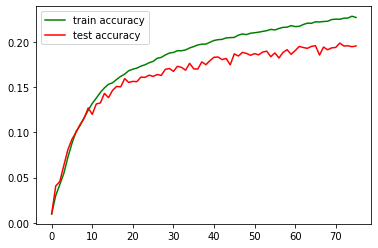

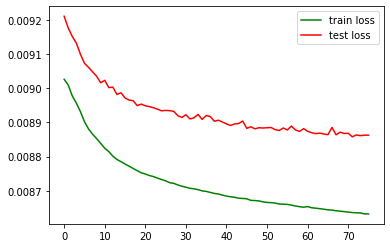

100%|███████████████████████████████████████████████████████████████████████████████| 75/75 [11:03<00:00,  8.84s/it]

Architecture:  (6, 8, 15, 32, 1, 1, 1, 1)
test acc: 0.1966


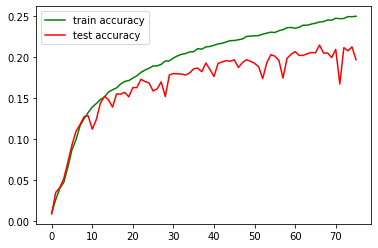

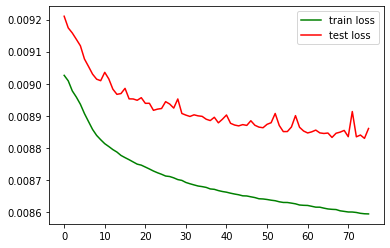

100%|███████████████████████████████████████████████████████████████████████████████| 75/75 [11:54<00:00,  9.52s/it]

Architecture:  (9, 8, 13, 33, 1, 1, 1, 1)
test acc: 0.19


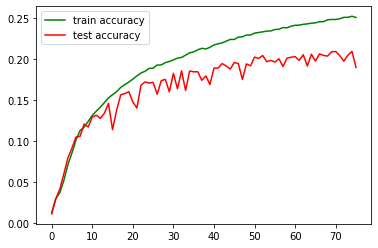

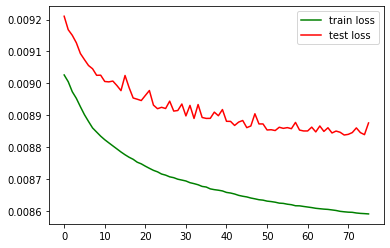

In [133]:
hyperparams_list = architectures
results = perform_experiments(device, trainloader, testloader,
                              ConvArchitecture2, architectures, epochs_n=75, repeats_n=1)

In [139]:
# замерджить файлы с колаба и с пк

with open("models_logs_gradsearch.json") as f:
    data_pc = json.load(f)
with open("models_logs_gradsearch_colab2.json") as f:
    data_colab = json.load(f)
with open("models_logs_gradsearch2.json", 'w') as f:
    json.dump(data_pc + list(reversed(data_colab)), f)

In [140]:
import statistics
import json

path = "models_logs_gradsearch2.json"
with open(path) as f:
    logs = json.load(f)
    
# initial_hyperparams = (4, 8, 16, 32, 1, 1, 1, 1)

data_to_compute_gradients = {}
for log in logs:
    configuration = log["model_info"]["configuration"]
    c1, c2, c3, c4, k1, k2, k3, k4 = tuple(configuration)
    num_of_params = architecture2(c1, c2, c3, c4, k1, k2, k3, k4).get_num_of_params()
    acc_avg = statistics.mean(log["statistics"]["testacc"][-10:])
    data_to_compute_gradients[tuple(configuration)] =  (num_of_params, acc_avg)
    
def get_N(hyperparams, data_to_compute_gradients):
    return data_to_compute_gradients[hyperparams][0]

def get_acc(hyperparams, data_to_compute_gradients):
    return data_to_compute_gradients[hyperparams][1]

def get_grad_N(hyperparams, data_to_compute_gradients):
    grad = []
    for i in range(len(hyperparams)):
        hyperparams_tmp = list(hyperparams)
        hyperparams_tmp[i] += 1
        grad.append(get_N(tuple(hyperparams_tmp), data_to_compute_gradients) 
                    - get_N(hyperparams, data_to_compute_gradients))
    return np.array(grad)

def get_grad_acc(hyperparams, data_to_compute_gradients):
    grad = []
    for i in range(len(hyperparams)):
        hyperparams_tmp = list(hyperparams)
        hyperparams_tmp[i] += 1
        grad.append(get_acc(tuple(hyperparams_tmp), data_to_compute_gradients) 
                    - get_acc(hyperparams, data_to_compute_gradients))
    return np.array(grad)

In [141]:
data_to_compute_gradients

{(4, 4, 4, 4, 1, 1, 1, 1): (1088, 0.09831),
 (5, 4, 4, 4, 1, 1, 1, 1): (1154, 0.08505),
 (4, 8, 16, 32, 1, 1, 1, 1): (9636, 0.19057),
 (5, 8, 16, 32, 1, 1, 1, 1): (9738, 0.19894),
 (4, 9, 16, 32, 1, 1, 1, 1): (9819, 0.19246),
 (4, 8, 17, 32, 1, 1, 1, 1): (9999, 0.20069),
 (4, 8, 16, 33, 1, 1, 1, 1): (9883, 0.20607),
 (4, 8, 16, 32, 2, 1, 1, 1): (9784, 0.19551),
 (4, 8, 16, 32, 1, 2, 1, 1): (10220, 0.18505),
 (4, 8, 16, 32, 1, 1, 2, 1): (11956, 0.19873),
 (4, 8, 16, 32, 1, 1, 1, 2): (18884, 0.22195),
 (5, 8, 15, 32, 1, 1, 1, 1): (9375, 0.19415),
 (6, 8, 15, 32, 1, 1, 1, 1): (9477, 0.20272),
 (9, 8, 13, 33, 1, 1, 1, 1): (9277, 0.20241),
 (13, 9, 10, 33, 1, 1, 1, 1): (8779, 0.19402999999999998)}

In [108]:
grad_N = get_grad_N(initial_hyperparams, data_to_compute_gradients)
grad_acc = get_grad_acc(initial_hyperparams, data_to_compute_gradients)
print(grad_N)
print(grad_acc)
cosine = np.dot(grad_N, grad_acc) / np.linalg.norm(grad_N) / np.linalg.norm(grad_acc)
print(cosine)

direction_to_change_params = grad_acc - np.dot(grad_N, grad_acc) / np.dot(grad_N, grad_N) * grad_N
direction_to_change_params /= np.linalg.norm(direction_to_change_params)
print(direction_to_change_params)

[ 102  183  363  247  148  584 2320 9248]
[ 0.01341  0.00114 -0.00821  0.0025  -0.00806 -0.01852 -0.00484  0.01838]
0.47680671372324807
[ 0.47096412  0.03015191 -0.31246319  0.07487307 -0.29493887 -0.6915328
 -0.30362563  0.12903243]


In [128]:
print("initial: ", initial_hyperparams)

for K in range(20):

    new_hyperparams = initial_hyperparams + K*direction_to_change_params
    # print(new_hyperparams)
    new_hyperparams[4] = 1
    new_hyperparams[5] = 1
    new_hyperparams[6] = 1
    new_hyperparams[7] = 1
    print("new:     ", tuple(np.rint(new_hyperparams).astype(int)))

    c1, c2, c3, c4, k1, k2, k3, k4 = tuple(np.rint(new_hyperparams).astype(int))
    print(K, architecture2(c1, c2, c3, c4, k1, k2, k3, k4).get_num_of_params())
    print("\n")

initial:  (4, 8, 16, 32, 1, 1, 1, 1)
new:      (4, 8, 16, 32, 1, 1, 1, 1)
0 9636


new:      (4, 8, 16, 32, 1, 1, 1, 1)
1 9636


new:      (5, 8, 15, 32, 1, 1, 1, 1)
2 9375


new:      (5, 8, 15, 32, 1, 1, 1, 1)
3 9375


new:      (6, 8, 15, 32, 1, 1, 1, 1)
4 9477


new:      (6, 8, 14, 32, 1, 1, 1, 1)
5 9114


new:      (7, 8, 14, 32, 1, 1, 1, 1)
6 9216


new:      (7, 8, 14, 33, 1, 1, 1, 1)
7 9445


new:      (8, 8, 14, 33, 1, 1, 1, 1)
8 9547


new:      (8, 8, 13, 33, 1, 1, 1, 1)
9 9175


new:      (9, 8, 13, 33, 1, 1, 1, 1)
10 9277


new:      (9, 8, 13, 33, 1, 1, 1, 1)
11 9277


new:      (10, 8, 12, 33, 1, 1, 1, 1)
12 9007


new:      (10, 8, 12, 33, 1, 1, 1, 1)
13 9007


new:      (11, 8, 12, 33, 1, 1, 1, 1)
14 9109


new:      (11, 8, 11, 33, 1, 1, 1, 1)
15 8737


new:      (12, 8, 11, 33, 1, 1, 1, 1)
16 8839


new:      (12, 9, 11, 33, 1, 1, 1, 1)
17 9049


new:      (12, 9, 10, 33, 1, 1, 1, 1)
18 8668


new:      (13, 9, 10, 33, 1, 1, 1, 1)
19 8779




In [129]:
architectures = [(5, 8, 15, 32, 1, 1, 1, 1),
                 (6, 8, 15, 32, 1, 1, 1, 1),
                 (9, 8, 13, 33, 1, 1, 1, 1)
                ]

In [ ]:
architectures = [(9, 8, 13, 33, 1, 1, 1, 1),
                 (13, 9, 10, 33, 1, 1, 1, 1)
                ]